In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#; plt.style.use('seaborn-whitegrid')
import plotly.express as px
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
from datetime import datetime


from tensorflow.keras.losses import huber



In [276]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
    
df = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)

df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

df['pollution'].fillna(0, inplace=True)
df.drop(['wnd_dir'], axis=1, inplace=True, errors='ignore')

df = df.groupby([d.strftime('%Y-%m-%d') for d in df.index]).mean()
df.index = pd.to_datetime(df.index)
df = df.groupby(np.arange(len(df))//7).mean()
# index = df.index[1::7] #or we can do this instead 
df.index = pd.date_range(start='1/1/2010', end='12/31/2014', freq='w')

In [588]:
df

,pollution,dew,temp,press,wnd_spd,snow,rain
2010-01-03,60.571429,-18.255952,-10.202381,1027.910714,43.859821,2.125000,0.000000
2010-01-10,70.946429,-19.035714,-10.029762,1030.035714,45.392083,0.000000,0.000000
2010-01-17,163.660714,-12.630952,-4.946429,1030.386905,17.492976,0.000000,0.000000
2010-01-24,41.017857,-17.404762,-2.672619,1026.196429,54.854048,0.000000,0.000000
2010-01-31,53.410714,-17.565476,-2.083333,1025.273810,26.625119,0.000000,0.000000
...,...,...,...,...,...,...,...
2014-11-30,84.250000,-14.988095,-0.446429,1025.476190,76.424643,0.000000,0.005952
2014-12-07,79.255952,-14.375000,-1.303571,1029.607143,22.218869,0.005952,0.000000
2014-12-14,75.410714,-15.916667,-2.244048,1028.380952,59.875893,0.000000,0.000000
2014-12-21,48.690476,-15.089286,-0.505952,1027.339286,98.139345,0.000000,0.000000


calculating di's , yt - yt-1 = makes a unit root, stationary

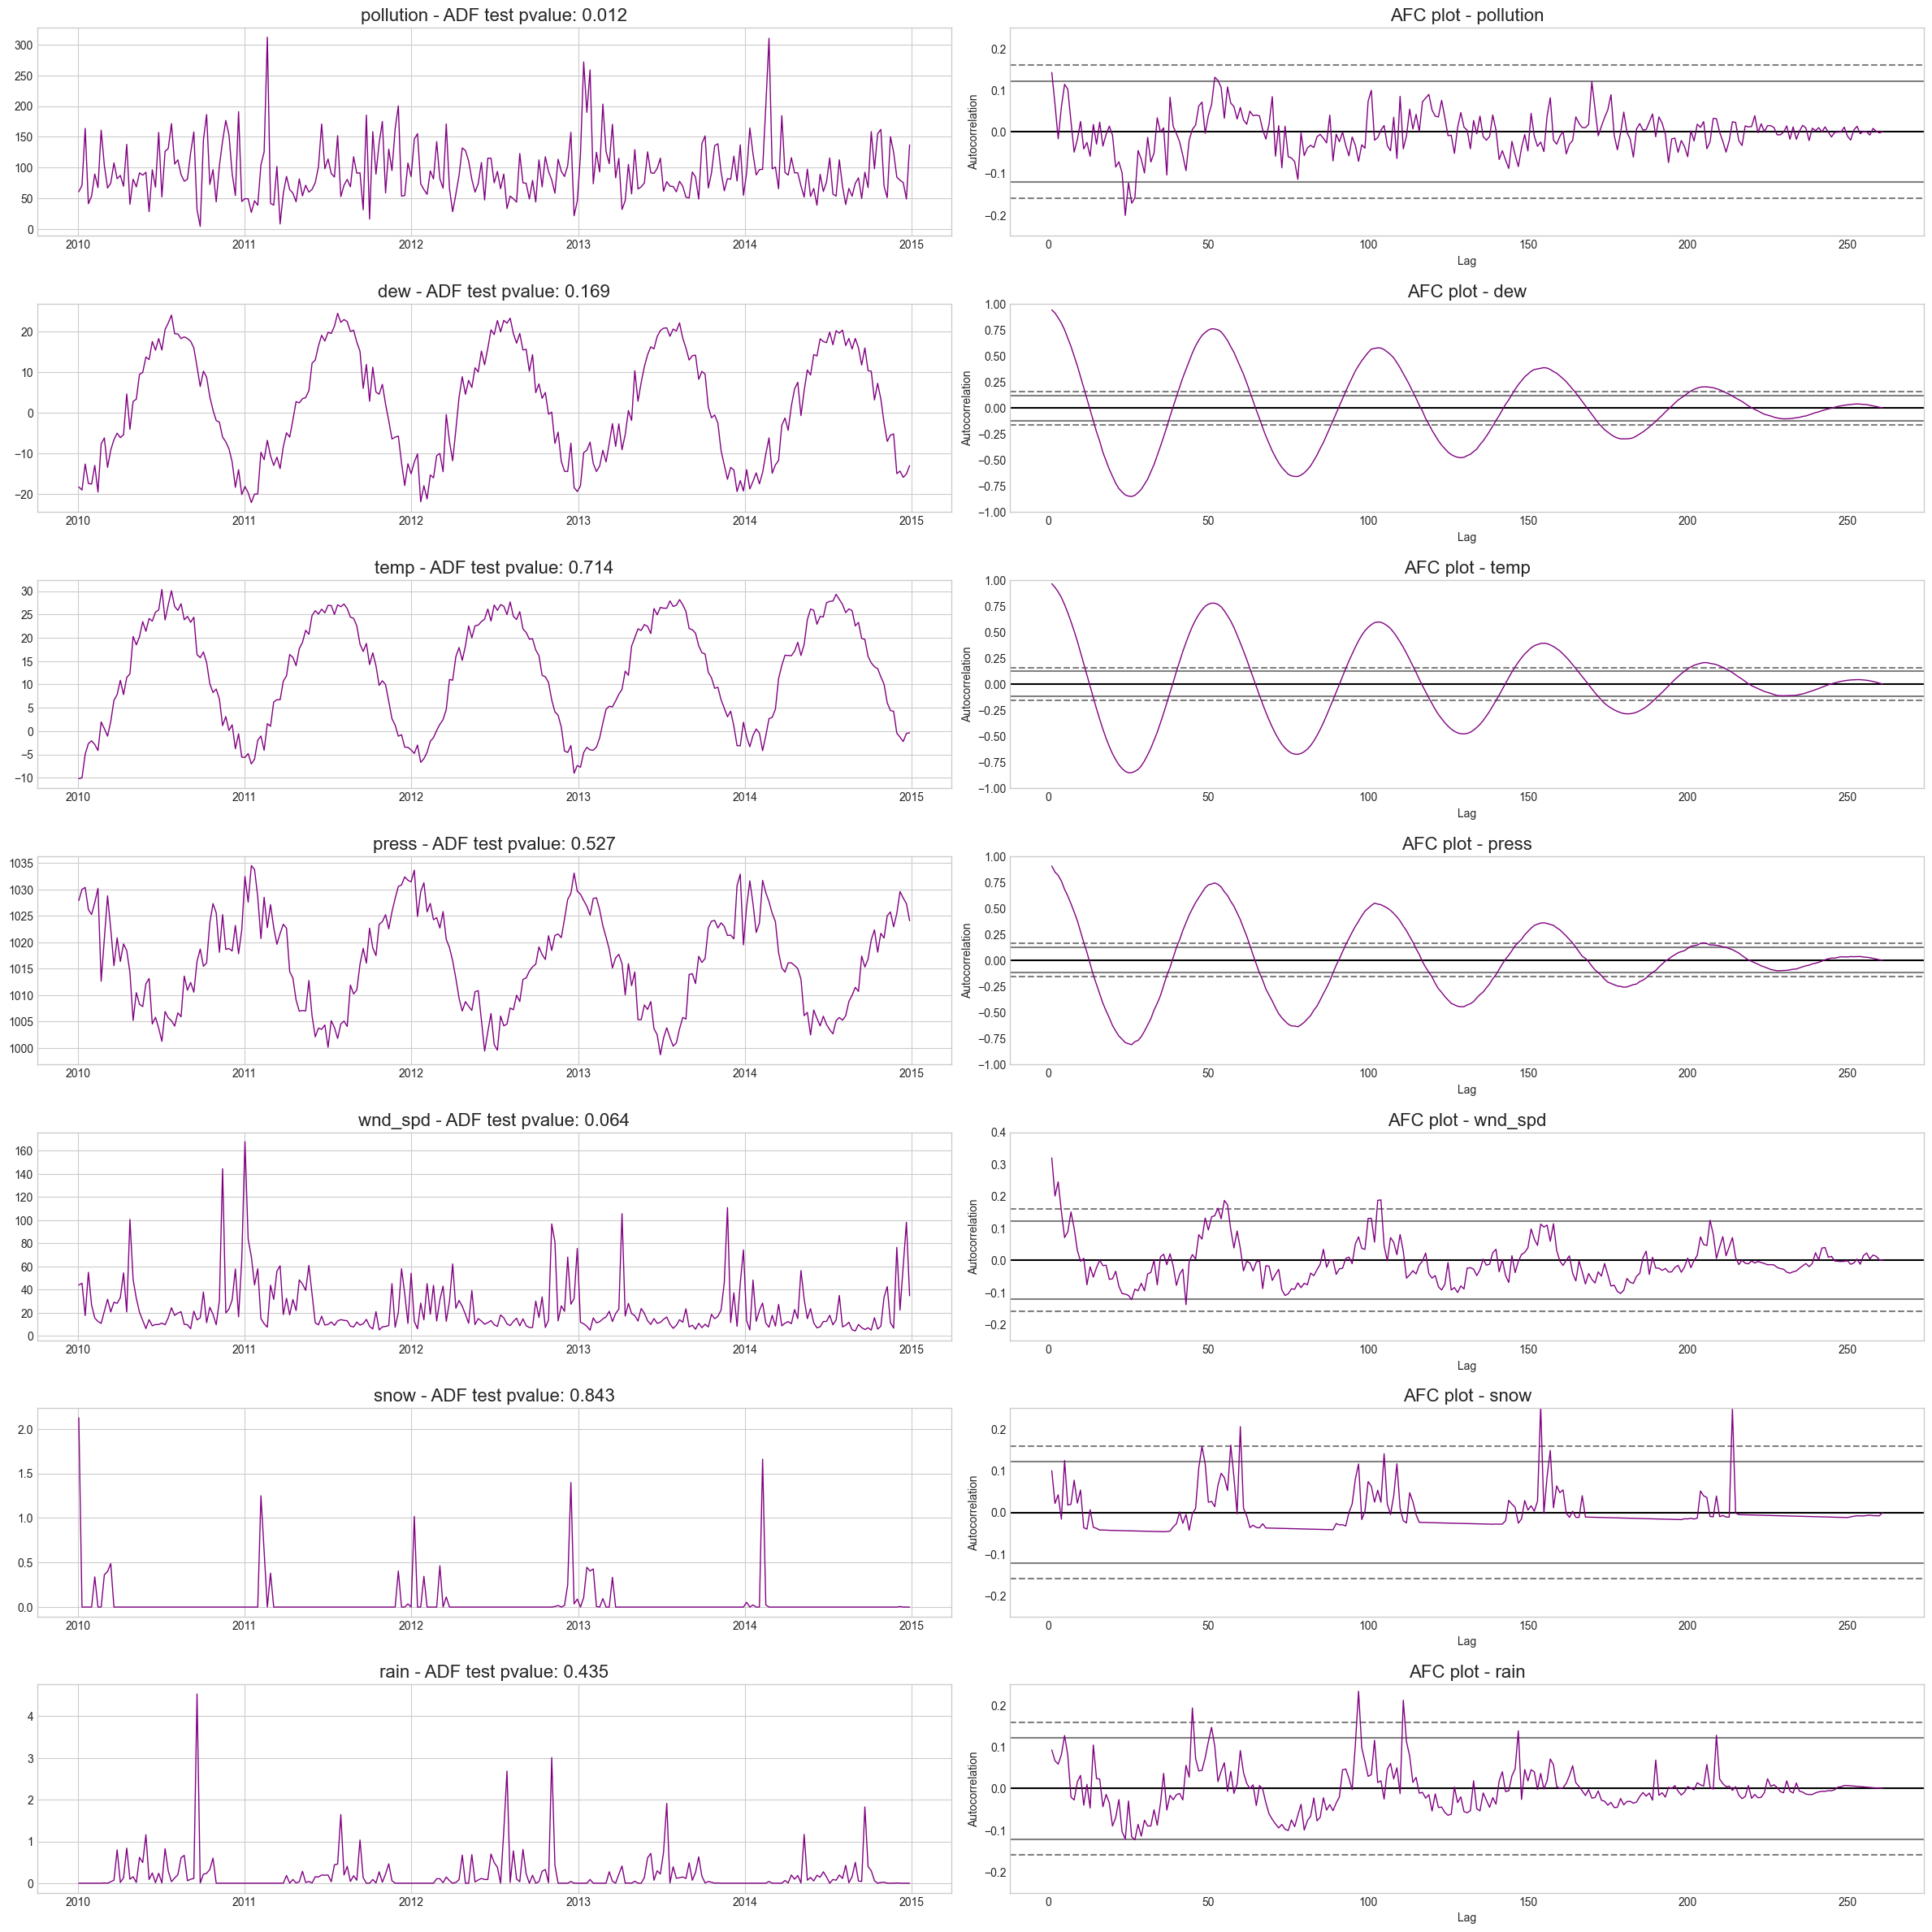

In [314]:
fig, axes = plt.subplots(7, 2, dpi=100, figsize=(24, 24))
axes = axes.ravel()
ylims = [(-.25, .25), (-1, 1), (-1, 1), (-1, 1), (-.25, .4), (-.25, .25), (-.25, .25), (-.25, .25)]
for i in range(0, 7):
	col = df.columns.to_list()[i]
	result = adfuller(df[col].values, maxlag=56, regression='ctt', autolag='t-stat')
	axes[2*i].plot(df[col], lw=1, color='purple')
	axes[2*i].set_title(f'{col} - ADF test pvalue: {int(1000*result[1])/1000}', fontsize=16); axes[2*i+1].set_title(f'AFC plot - {col}', fontsize=16);
	autocorrelation_plot(df[col], ax=axes[2*i+1], lw=1, color='purple').set_ylim(ylims[i])
fig.tight_layout(pad=1.5)
plt.show()

In [235]:
def visualize_results(train, predictions, model_name):
    plt.figure(figsize=(16, 4), dpi=100)
    plt.plot(train, lw=1, label='real')
    plt.plot(predictions, color='red', lw=1, label='pred')
    plt.title(f'{model_name} Model')
    plt.legend()
    plt.xlabel = pd.date_range(start='1/1/2010', end='12/31/2014', freq='w')
    plt.show()

Univariants : 

AR : The method is suitable for univariate time series without trend and without seasonal components, when the series is stationary

ARMA : It combines both Autoregression (AR) and Moving Average (MA) models., The method is suitable for univariate time series without trend and seasonal components.

ARIMA : It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I)., The method is suitable for univariate time series with trend and without seasonal components.



Multi Variants : 
AR with exogeneous varibales : The method is suitable for multivariate time series without trend and seasonal components


In [565]:
def calculate_loss(train, predictions, model_name, a, b) : 
    y_true = train[a:]
    y_pred = predictions[a:b]
    print(f'{model_name} Huber loss is : {huber(y_true, y_pred, delta=1.0)}') 

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

X = df.pollution.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(len(X), 1))
X = X.reshape(X.shape[0])
train, test = X[1:len(X)-56], X[len(X)-56:]



# AR
model = AutoReg(train, lags=12)
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1, dynamic=False)
visualize_results(train, predictions, 'AR(12) (Univariant)')



# AR
model = AutoReg(train, lags=56)
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1, dynamic=False)
visualize_results(train, predictions, 'AR(56) (Univariant)')


# ARIMA
predictions = [None for i in range(len(train) - len(test))]
history = [x for x in train]
test = [x for x in test]
for t in range(len(test)*2):
	model = ARIMA(history, order=(5, 1, 0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat); history.append(test[t]); test.append(yhat)
visualize_results(train, predictions, 'ARIMA (Univariant)')


# MA
predictions = [None for i in range(len(train) - len(test))]
history = [x for x in train]
test = [x for x in test]
for t in range(len(test)*2):
	model = ARIMA(history, order=(0, 0, 3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat); history.append(test[t]); test.append(yhat)
visualize_results(train, predictions, 'MA (Univariant)')




Multivariant AR

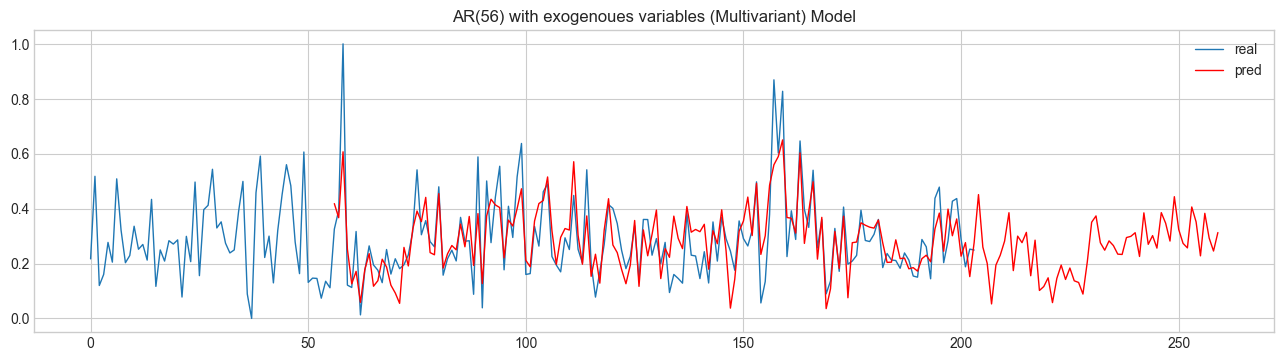

AR (multivariant) Huber loss is : 0.004499076399952173


In [566]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = df.pollution.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(len(X), 1))
X = X.reshape(X.shape[0])
train, test = X[1:len(X)-56], X[len(X)-56:]
train2 = df.values[1:len(X)-56, 1:]
test2 = df.values[len(X)-56:, 1:]


model = AutoReg(train, exog=train2, lags=56)
model_fit = model.fit()
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1, dynamic=False, exog_oos=test2)
visualize_results(train, predictions, 'AR(56) with exogenoues variables (Multivariant)')

LSTM (Univariant)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df.columns
idx = df.index
new_df = pd.DataFrame(scaler.fit_transform(df), columns=cols)
new_df.index = idx



from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=56, output_dim=56))
model.add(layers.LSTM(56, activation='linear', return_sequences=False))
model.add(layers.Dense(56, activation='linear'))
model.add(layers.Dense(56))

model.compile(loss='huber', optimizer='adagrad')



for epoch in range(0, len(df)- 56*2 - 1, 1) : 
    #print(f'epoch: {epoch}')
    x = new_df.pollution[epoch:56+epoch].values
    y = new_df.pollution[56+epoch:2*56+epoch].values
    model.fit(x, y, shuffle=False, verbose=0, batch_size=1)


pred = model.predict(new_df.pollution[len(df)-56:len(df)].values)[0]
pred = pd.Series(pred)
pred.index = pd.date_range(start='12/29/2014', end='1/29/2016', freq='w')

visualize_results(new_df.pollution, pred, 'LSTM (Huber Loss & Adagrad Optimizer & Linear Activations)')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df.columns
idx = df.index
new_df = pd.DataFrame(scaler.fit_transform(df), columns=cols)
new_df.index = idx



from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=56, output_dim=56))
model.add(layers.SimpleRNN(56, activation='linear', return_sequences=True))
model.add(layers.SimpleRNN(56, activation='linear', return_sequences=False))
model.add(layers.Dense(56))
model.add(layers.Dense(56))

model.compile(loss='huber', optimizer='adagrad')


for epoch in range(0, len(df)- 56*2 - 1, 1) : 
    #print(f'epoch: {epoch}')
    x = new_df.pollution[epoch:56+epoch].values
    y = new_df.pollution[56+epoch:2*56+epoch].values
    model.fit(x, y, shuffle=False, verbose=0, batch_size=1)


pred = model.predict(new_df.pollution[len(df)-56:len(df)].values)[0]
pred = pd.Series(pred)
pred.index = pd.date_range(start='12/29/2014', end='1/29/2016', freq='w')

visualize_results(new_df.pollution, pred, 'Vanilla RNN (Huber Loss & adagrad Optimizer & Linear Activations)')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df.columns
idx = df.index
new_df = pd.DataFrame(scaler.fit_transform(df), columns=cols)
new_df.index = idx



from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Conv1D(56, kernel_size=(2), activation='tanh', padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(56, activation='tanh'))

model.compile(loss='huber', optimizer='adagrad')


for epoch in range(0, len(df)- 56*2 - 1, 1) : 
    #print(f'epoch: {epoch}')
    x = new_df[epoch:56+epoch].values.reshape((56, 7, 1, 1))
    y = new_df[56+epoch:2*56+epoch].values.reshape((56, 7, 1, 1))
    model.fit(x, y, shuffle=False, verbose=0, batch_size=1)


pred = model.predict(new_df[len(df)-56:len(df)].values.reshape((56, 7, 1, 1)))[0]
pred = pd.Series(pred)
pred.index = pd.date_range(start='12/29/2014', end='1/29/2016', freq='w')


visualize_results(new_df.pollution, pred, 'CNN (Huber Loss & Adagrad Optimizer & tanh Activations)')


In [ ]:
new_idxs = pd.date_range(start='12/29/2014', end='1/29/2016', freq='w')
future=pd.DataFrame({'date':new_idxs})

from fbprophet import Prophet
model = Prophet()
model.fit(df)
forecast = model.predict(future)